In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
import iris.plot as iplt
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import time

from Identify_Events_Functions import *

pd.set_option('display.float_format', '{:.3f}'.format)

In [66]:
cs = concat_cube.coord_system()
cs.grid_north_pole_longitude

AttributeError: 'TransverseMercator' object has no attribute 'grid_north_pole_longitude'

In [83]:
def find_position_obs (concat_cube, rain_gauge_lat, rain_gauge_lon, plot_radius = 500, plot=False):
    lat_length = concat_cube.shape[0]
    lon_length = concat_cube.shape[1]
    
    ### Rain gauge data 
    # Convert WGS84 coordinate to BNG
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
    # Use the transformer to convert longitude and latitude to British National Grid coordinates
    rain_gauge_lon_bng, rain_gauge_lat_bng = transformer.transform(rain_gauge_lon, rain_gauge_lat)
    
    # Create as a list
    rain_gauge_point = [('grid_latitude', rain_gauge_lat_bng), ('grid_longitude', rain_gauge_lon_bng)]
                 
    ### Model data
    # Create a list of all the tuple pairs of latitude and longitudes
    locations = list(itertools.product(concat_cube.coord('projection_y_coordinate').points,
                                       concat_cube.coord('projection_x_coordinate').points))
    
    # Find the index of the nearest neighbour of the rain gague location point in the list of locations present in concat_cube
    tree = spatial.KDTree(locations)
    closest_point_idx = tree.query([(rain_gauge_point[0][1], rain_gauge_point[1][1])], k =1)[1][0]
    
    # Create a list of all the tuple positions
    indexs_lst = [(i, j) for i in range(lat_length) for j in range(lon_length)]
    selected_index = indexs_lst[closest_point_idx]
    print(selected_index)
    
    # Check if the selected index is masked and find a nearby valid index if necessary
    # Define the search order of neighboring cells relative to the original index
    neighbor_offsets = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, 1), (1, -1), (-1, -1)]

    # Check if the selected index is masked and find a nearby valid index if necessary
    if np.ma.is_masked(concat_cube[selected_index[0], selected_index[1]].data):
        print("yep its masked")
        found = False
        for di, dj in neighbor_offsets:
            ni, nj = selected_index[0] + di, selected_index[1] + dj
            # Check if the index is within bounds and not masked
            if 0 <= ni < lat_length and 0 <= nj < lon_length and not np.ma.is_masked(concat_cube[ni, nj].data):
                # Update the closest_point_idx and selected_index if a non-masked index is found
                closest_point_idx = indexs_lst.index((ni, nj))
                selected_index = (ni, nj)
                found = True
                print(selected_index)
                break
            # If no unmasked index is found among neighboring cells in the first ring, check the next ring
            neighbor_offsets = [(2, 0), (-2, 0), (0, 2), (0, -2), (2, 2), (-2, 2), (2, -2), (-2, -2)]
            if not found:
                print("No unmasked index found among neighboring cells in the first ring.")
                for di, dj in neighbor_offsets:
                    ni, nj = selected_index[0] + di, selected_index[1] + dj
                    # Check if the index is within bounds and not masked
                    if 0 <= ni < lat_length and 0 <= nj < lon_length and not np.ma.is_masked(concat_cube[ni, nj].data):
                        # Update the closest_point_idx and selected_index if a non-masked index is found
                        closest_point_idx = indexs_lst.index((ni, nj))
                        selected_index = (ni, nj)
                        found = True
                        print(selected_index)
                        break
                # If no unmasked index is found among neighboring cells in the second ring, print a message
                if not found:
                    print("No unmasked index found among neighboring cells in the second ring.")
        
       
    ######## Check by plotting         
    if plot == True:
        
        # Get cube containing one hour worth of data
        hour_uk_cube = concat_cube

        # Set all the values to 0
        test_data = np.full((hour_uk_cube.shape),0,dtype = int)
        # Set the values at the index position fond above to 1
        test_data[selected_index[0],selected_index[1]] = 1
        # Mask out all values that aren't 1
        test_data = ma.masked_where(test_data<1,test_data)

        # Set the dummy data back on the cube
        hour_uk_cube.data = test_data

        # Find cornerpoint coordinates (for use in plotting)
        lats_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[0]
        lons_cornerpoints = find_cornerpoint_coordinates_obs(hour_uk_cube)[1]

        # Trim the data timeslice to be the same dimensions as the corner coordinates
        hour_uk_cube = hour_uk_cube[1:,1:]
        test_data = hour_uk_cube.data

        # Create location in web mercator for plotting
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        lon_rain_gauge_wm, lat_rain_gauge_wm = transformer.transform(rain_gauge_lon,rain_gauge_lat)

        # Create bounding box to centre the map on
        min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(rain_gauge_lat, rain_gauge_lon, distance_km =plot_radius)
        gdf_bbox = create_geodataframe_from_bbox(min_lat, max_lat, min_lon, max_lon)
        gdf_bbox_web_mercator = gdf_bbox.to_crs(epsg=3857)

        # Create a colormap
        cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

        fig, ax = plt.subplots(figsize=(8,8))
        extent = tilemapbase.extent_from_frame(gdf_bbox_web_mercator)
        plot = plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=200)
        plot =plotter.plot(ax)
        # # Add edgecolor = 'grey' for lines
        plot =ax.pcolormesh(lons_cornerpoints, lats_cornerpoints, test_data,
              linewidths=0.1, alpha = 1, cmap = cmap, edgecolors = 'grey')
        plot = ax.xaxis.set_major_formatter(plt.NullFormatter())
        plot = ax.yaxis.set_major_formatter(plt.NullFormatter())
        plt.plot(lon_rain_gauge_wm, lat_rain_gauge_wm, 'o', color='black', markersize = 10)     
        
        plt.show()

    return locations[closest_point_idx], (indexs_lst[closest_point_idx][0],indexs_lst[closest_point_idx][1])


def find_gauge_Tb0_and_location_in_grid (gauge_num, sample_cube):
    # Get data just for this gauge
    gauge1 = tbo_vals.iloc[gauge_num]
    # Find the interevent arrival time (Tb0)
    Tb0 = int(gauge1['Critical_interarrival_time'])
    # Find the coordinates of the cell containing this gauge
    closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot_radius = 10, plot=True)
    
    return Tb0, idx_2d


(825, 891)


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:89: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


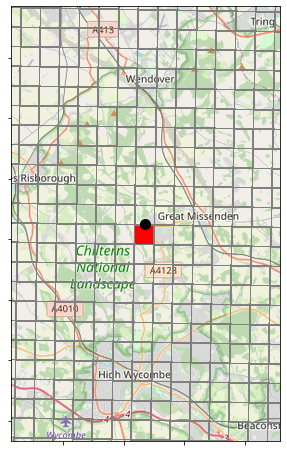

In [77]:
from pyproj import Proj, transform
### Read in a sample cube for finding the location of gauge in grid
sample_cube = iris.load(f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/Filtered_100/2012/metoffice-c-band-rain-radar_uk_20120602_30mins.nc')[0][1,:,:]

# Get tb0 values at each gauge
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(1, sample_cube)

(825, 891)


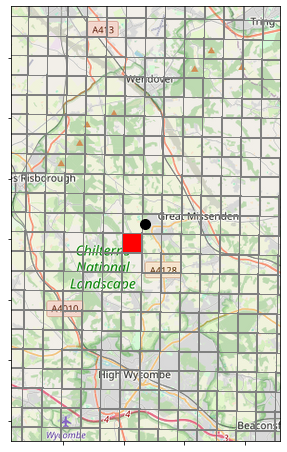

In [84]:
from pyproj import Proj, transform
### Read in a sample cube for finding the location of gauge in grid
sample_cube = iris.load(f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/Filtered_100/2012/metoffice-c-band-rain-radar_uk_20120602_30mins.nc')[0][1,:,:]

# Get tb0 values at each gauge
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(1, sample_cube)

### Get all data for this grid cell

In [7]:
# # Define the directory and create a sorted list of file paths
# year = 2016
# radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
# file_list = glob.glob(radardir + "*.nc")
# sorted_list = sorted(file_list)

In [6]:
# # Load the cubes
# cubes = iris.load(sorted_list[:30])

# common_metadata = cubes[0].metadata

# # Update metadata of all cubes
# for cube in cubes:
#     cube.metadata = common_metadata  

# # Concatenate into a single cube
# monthly_cube = cubes.concatenate_cube()

### Find the maximum value

In [16]:
# Define the directory and create a sorted list of file paths#
for year in range(2006,2020):
    start_time=time.time()
    print(year)
    radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    file_list = glob.glob(radardir + "*.nc")
    sorted_list = sorted(file_list)

    # Load the cubes
    cubes = iris.load(sorted_list[:30])

    common_metadata = cubes[0].metadata

    # Update metadata of all cubes
    for cube in cubes:
        cube.metadata = common_metadata  

    # Concatenate into a single cube
    monthly_cube = cubes.concatenate_cube()

    this_grid_cell = monthly_cube[:,idx_2d[0], idx_2d[1]]

    print(np.nanmax(this_grid_cell.data))
    end =time.time()
    print(end-start_time)
very_end=time.time()
print(very_end-start_time)

2006
13.562753677368164
2007
115.72815418243408
2008
222.2383337020874
2009


KeyboardInterrupt: 

In [31]:
import xarray as xr

def process_file(file_path):
    # Load the dataset using xarray
    ds = xr.open_dataset(file_path)
    # print(ds.data_vars)
    # Check for the variable of interest and extract it
    if 'rain_rate_composite' in ds:
        variable_name = 'rain_rate_composite'
    elif 'Rainfall rate Composite' in ds:
        variable_name = 'Rainfall rate Composite'
    elif 'rainfall_rate_composite' in ds:
        variable_name = 'rainfall_rate_composite'        
    else:
        raise ValueError("Neither 'rain_rate_composite' nor 'Rainfall rate Composite' found in the dataset")
    
    # Extract the grid cell of interest
    this_grid_cell = ds[variable_name].isel(projection_y_coordinate=70, projection_x_coordinate=405)
    
    # Compute the maximum value
    max_value = this_grid_cell.max().item()
    
    return max_value

# Define the directory and create a sorted list of file paths
file_paths = []
for year in range(2006, 2020):
    radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    file_list = glob.glob(radardir + "*.nc")
    sorted_list = sorted(file_list)[:30]
    file_paths.extend(sorted_list)

# Process files in parallel
results = [process_file(file_path) for file_path in file_paths]

# Compute results
max_value = max(results)
start_time=time.time()
very_end=time.time()
print(very_end-start_time)

7.033348083496094e-05


In [33]:
def find_seasonal_max(radardir):
    file_list = glob.glob(radardir + "*.nc")
    sorted_list = sorted(file_list)

    # Load the cubes
    cubes = iris.load(sorted_list)

    common_metadata = cubes[0].metadata

    # Update metadata of all cubes
    for cube in cubes:
        cube.metadata = common_metadata  

    # Concatenate into a single cube
    monthly_cube = cubes.concatenate_cube()

    this_grid_cell = monthly_cube[:,idx_2d[0], idx_2d[1]]
    return np.nanmax(this_grid_cell.data)

# Define the directory and create a sorted list of file paths
filepaths = []
for year in range(2006,2020):
    filepath = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    filepaths.append(filepath)

# Process files in parallel
results = [find_monthly_max(file_path) for file_path in filepaths]
results

In [34]:
# Define the directory and create a sorted list of file paths
filepaths = []
for year in range(2006,2020):
    filepath = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    filepaths.append(filepath)

# Process files in parallel
results = [find_seasonal_max(file_path) for file_path in filepaths]
results

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [22]:
import dask
from dask import delayed

def process_file(file_path):
    cubes = iris.load(file_path)
    common_metadata = cubes[0].metadata
    for cube in cubes:
        cube.metadata = common_metadata  
    monthly_cube = cubes.concatenate_cube()
    this_grid_cell = monthly_cube[:,idx_2d[0], idx_2d[1]]
    return np.nanmax(this_grid_cell.data)

# Define the directory and create a sorted list of file paths
file_paths = []
for year in range(2006, 2007):
    radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    file_list = glob.glob(radardir + "*.nc")
    sorted_list = sorted(file_list)[:30]
    file_paths.extend(sorted_list)

# Process files in parallel
results = [process_file(file_path) for file_path in file_paths]
results
# Compute results
# max_value = max(results)

[0.21875,
 0.0625,
 0.0,
 1.65625,
 0.03125,
 0.03125,
 1.84375,
 0.0,
 0.0,
 0.0,
 0.3125,
 0.03125,
 5.5,
 0.125,
 0.0,
 0.0625,
 0.0,
 0.0,
 0.40625,
 4.8125,
 1.71875,
 0.0,
 0.0,
 6.71875,
 0.0625,
 1.40625,
 0.0,
 0.0,
 0.0,
 0.0]

In [20]:
file_paths = []
for year in range(2005, 2006):
    radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    file_list = glob.glob(radardir + "*.nc")
    sorted_list = sorted(file_list)
    file_paths.extend(sorted_list)
file_paths

[]

In [21]:
radardir

'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/2005/'